In [ ]:
https://towardsdatascience.com/how-to-encode-time-series-into-images-for-financial-forecasting-using-convolutional-neural-networks-5683eb5c53d9

## Import packages

In [11]:
import pandas as pd
import numpy as np
import talib as ta
import yfinance as yf
from matplotlib import pyplot as plt
from pyts.image import GramianAngularField
from talib import abstract
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Download data

In [2]:
def get_data(symbol = "NG=F", show_plot = True):
    #raw = yf.download("eurusd=x", period="ytd", interval='1h')
    raw = yf.download(symbol, period="1w", interval='5m')
    #raw = raw['Close']
    raw = pd.DataFrame(raw)
    raw = raw.drop(['Adj Close', 'Volume'], axis=1)
    raw['returns'] = np.log(raw.Close / raw.Close.shift(1))
    
    if show_plot:
        raw['Close'].plot(figsize=(20,7), fontsize = 16)
        plt.style.use("seaborn")
        plt.show()
        
    return raw    



[*********************100%***********************]  1 of 1 completed


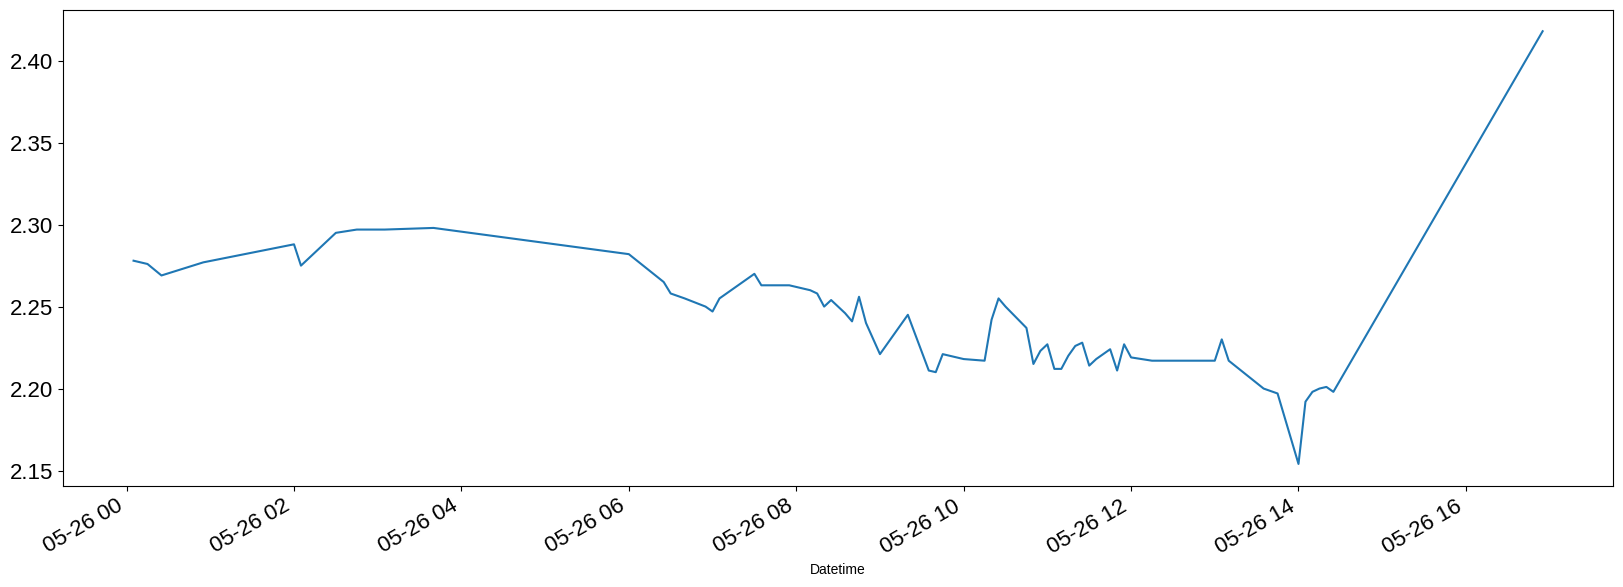

,Open,High,Low,Close,returns
Datetime,,,,,
2023-05-26 00:05:00-04:00,2.286,2.286,2.278,2.278,NaN
2023-05-26 00:15:00-04:00,2.276,2.276,2.276,2.276,-0.000878
2023-05-26 00:25:00-04:00,2.276,2.276,2.269,2.269,-0.003080
2023-05-26 00:55:00-04:00,2.277,2.277,2.277,2.277,0.003520
2023-05-26 02:00:00-04:00,2.292,2.297,2.288,2.288,0.004819


In [3]:
raw_data = get_data(symbol = "NG=F", show_plot = True)
raw_data.head()

## Adding Feature

In [4]:
def get_feature(df):         
    df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
    df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
    df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
    df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
    df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
    df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
    df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)           

    df.dropna(inplace = True)
    cols = df.columns 
    return df, cols

In [5]:
df, columns = get_feature(raw_data)

In [6]:
def trading_action(data, index):
    """
    :param data: DataFrame 
    :param index: Date Index for slicing
    :return: Folder destination as String
    """
    future_open = data[data['DateTime'].dt.date.astype(str) == index]['Open'].iloc[0]
    future_close = data[data['DateTime'].dt.date.astype(str) == index]['Open'].iloc[-1]
    if future_open < future_close:
        decision = 'LONG'
    else:
        decision = 'SHORT'
    return decision

In [9]:
def set_gaf_data(df):
    """
    :param df: DataFrame data
    :return: None
    """
    #dates = df.index.dt.date
    #dates = dates.drop_duplicates()
    index = 15 # rows of data used on each GAF
    # Container to store data for the creation of GAF
    decision_map = {key: [] for key in ['LONG', 'SHORT']}
    while True:
        if index >= len(list_dates) - 1:
            break
        # Select appropriate timeframe
        data_slice = df.loc[(df['DateTime'] > list_dates[index - 20]) & (df['DateTime'] < list_dates[index])]
        gafs = []
        # Group data_slice by time frequency
        for freq in ['1h', '2h', '4h', '1d']:
            group_dt = data_slice.groupby(pd.Grouper(key='DateTime', freq=freq)).mean().reset_index()
            group_dt = group_dt.dropna()
            gafs.append(group_dt['Close'].tail(20))
        # Decide what trading position we should take on that day
        future_value = df[df['DateTime'].dt.date.astype(str) == list_dates[index]]['Close'].iloc[-1]
        current_value = data_slice['Close'].iloc[-1]
        decision = trading_action(future_close=future_value, current_close=current_value)
        decision_map[decision].append([list_dates[index - 1], gafs])
        index += 1

In [10]:
set_gaf_data(df)

AttributeError: 'DatetimeIndex' object has no attribute 'dt'